## Sagnac Frequency - WEstring Case Study

## Imports

In [1]:
import os
import gc
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, date
from pandas import DataFrame, read_pickle, date_range, concat, read_csv
from obspy import UTCDateTime, read, Trace, Stream, read_inventory
from scipy.signal import hilbert


In [2]:
if os.uname().nodename == 'lighthouse':
    root_path = '/home/andbro/'
    data_path = '/home/andbro/kilauea-data/'
    archive_path = '/home/andbro/freenas/'
elif os.uname().nodename == 'kilauea':
    root_path = '/home/brotzer/'
    data_path = '/import/kilauea-data/'
    archive_path = '/import/freenas-ffb-01-data/'

In [3]:
# from functions.load_beat import __load_beat
from functions.load_sagnac_beat_data import __load_sagnac_beat_data
from functions.get_mlti_intervals import __get_mlti_intervals
from functions.mlti_intervals_to_NaN import __mlti_intervals_to_NaN
from functions.load_mlti import __load_mlti
from functions.smoothing import __smooth
from functions.interpolate_nan import __interpolate_nan

## Configurations

In [4]:
config = {}

case = 1
config['tbeg'] = UTCDateTime("2024-02-22 00:00")
config['tend'] = UTCDateTime("2024-02-29 00:00")
flim1, flim2 = 447.736, 447.75

config['path_to_sds'] = archive_path+"romy_archive/"

## path to Sagnac Beat data
config['path_to_autodata'] = archive_path+f"romy_autodata/"

config['path_to_figs'] = data_path+"sagnac_frequency/figures/"

In [5]:
beatV = __load_sagnac_beat_data(config['tbeg'], config['tend'], "V", config['path_to_autodata'])

## Remove breakdown periods

In [6]:
times = [("2024-01-01T04:00", "2024-01-01T22:51"),
         ("2024-01-03T14:20", "2024-01-06T00:00"),
         ("2023-12-19T09:40", "2023-12-19T15:21")]

for t1, t2 in times:
    beatV['fj'] = np.where((beatV.times_utc > t1) & (beatV.times_utc < t2), np.nan, beatV['fj'])

# beatV['fj'] = np.nan_to_num(beatV['fj'], nan=np.nanmedian(beatV['fj']))

## Load Maintenance LXX log

In [7]:
from functions.load_lxx import __load_lxx

lxx =__load_lxx(config['tbeg'], config['tend'], archive_path)

In [8]:
from functions.get_lxx_intervals import __get_lxx_intervals

lxx_t1, lxx_t2 = __get_lxx_intervals(lxx.datetime)

## Remove MLTI times

In [9]:
mltiV = __load_mlti(config['tbeg'], config['tend'], "V", archive_path)


In [10]:
mltiV_t1, mltiV_t2 = __get_mlti_intervals(mltiV.time_utc)


In [11]:
beatV = __mlti_intervals_to_NaN(beatV, "fj", "times_utc", mltiV_t1, mltiV_t2, t_offset_sec=180)


In [12]:
beatV

,dt,dummy_times,times_utc,times_utc_sec,times_mjd,fj,f1,f2,pz,p1,...,ac_z,ac_1,ac_2,dc_z,dc_1,dc_2,contrast_z,contrast_1,contrast_2,fj_nan
0,2024-02-22T00:00,2024-02-22T00:00:00.000000Z,2024-02-22T00:00:30.000000Z,30.0,60362.000347,447.744388,0.000000,0.000000,0.230074,0.000000,...,0.523603,0.000000,0.000000,0.345579,0.000000,0.000000,0.744135,0.000000,0.000000,447.744388
1,2024-02-22T00:01,2024-02-22T00:01:00.000000Z,2024-02-22T00:01:30.000000Z,90.0,60362.001042,447.744428,0.000000,0.000000,0.230085,0.000000,...,0.523627,0.000000,0.000000,0.345591,0.000000,0.000000,0.744149,0.000000,0.000000,447.744428
2,2024-02-22T00:02,2024-02-22T00:02:00.000000Z,2024-02-22T00:02:30.000000Z,150.0,60362.001736,447.744394,0.000000,0.000000,0.230093,0.000000,...,0.523639,0.000000,0.000000,0.345589,0.000000,0.000000,0.744175,0.000000,0.000000,447.744394
3,2024-02-22T00:03,2024-02-22T00:03:00.000000Z,2024-02-22T00:03:30.000000Z,210.0,60362.002431,447.744356,0.000000,0.000000,0.230082,0.000000,...,0.523596,0.000000,0.000000,0.345568,0.000000,0.000000,0.744160,0.000000,0.000000,447.744356
4,2024-02-22T00:04,2024-02-22T00:04:00.000000Z,2024-02-22T00:04:30.000000Z,270.0,60362.003125,447.744375,0.000000,0.000000,0.230061,0.000000,...,0.523553,0.000000,0.000000,0.345539,0.000000,0.000000,0.744186,0.000000,0.000000,447.744375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10077,2024-02-28T23:55,2024-02-28T23:55:00.000000Z,2024-02-28T23:55:30.000000Z,604530.0,60368.996875,447.741478,0.000000,0.000000,0.239081,0.000000,...,0.544240,0.000000,0.000000,0.351110,0.000000,0.000000,0.760656,0.000000,0.000000,447.741478
10078,2024-02-28T23:56,2024-02-28T23:56:00.000000Z,2024-02-28T23:56:30.000000Z,604590.0,60368.997569,447.741477,0.000000,0.000000,0.239074,0.000000,...,0.544246,0.000000,0.000000,0.351103,0.000000,0.000000,0.760667,0.000000,0.000000,447.741477
10079,2024-02-28T23:57,2024-02-28T23:57:00.000000Z,2024-02-28T23:57:30.000000Z,604650.0,60368.998264,447.741482,450.133889,450.133874,0.239069,0.003737,...,0.544289,2.447222,3.879457,0.351094,0.449700,0.716268,0.760733,0.817055,0.827023,447.741482
10080,2024-02-28T23:58,2024-02-28T23:58:00.000000Z,2024-02-28T23:58:30.000000Z,604710.0,60368.998958,447.741473,450.047033,450.047038,0.239069,0.003734,...,0.544295,2.445383,3.892395,0.351102,0.457331,0.733804,0.760700,0.816978,0.822510,447.741473


## Interpolate NaN values

In [13]:
beatV['fj_inter'] = __interpolate_nan(np.array(beatV.fj_nan))


## Smoothing

In [14]:
n_minutes = 15*60

beatV['fj_smooth'] = __smooth(beatV.fj_inter, n_minutes)


## Reduced

In [15]:
beatV['fj_reduced'] = beatV['fj_smooth'] - np.abs(np.nanmean(beatV['fj_smooth'].iloc[:500]))


beatV.times_utc.iloc[0]## Plotting

In [16]:
def __makeplot():

    Nrow, Ncol = 3, 1

    font = 12

    ref_date = UTCDateTime(beatZ.times_utc.iloc[0][:10])

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    # time_scaling = 1/86400
    time_scaling = 1

    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_inter, color="tab:blue", label="cleaned")
    ax[0].plot(beatZ.times_utc_sec*time_scaling, beatZ.fj_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[0].set_ylim(Zlower, Zupper)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("Horizontal ring (Hz)", fontsize=font)

    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_inter, color="tab:green", label="cleaned")
    ax[1].plot(beatU.times_utc_sec*time_scaling, beatU.fj_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[1].set_ylim(Ulower, Uupper)
    ax[1].ticklabel_format(useOffset=False)
    ax[1].set_ylabel("Northern ring (Hz)", fontsize=font)

    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj, color="tab:grey", alpha=0.3, label="raw")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_inter, color="tab:red", label="cleaned")
    ax[2].plot(beatV.times_utc_sec*time_scaling, beatV.fj_smooth, color="k", label=f"mov. avg. ({n_minutes} min)")
    ax[2].set_ylim(Vlower, Vupper)
    ax[2].set_ylim()

    ax[2].ticklabel_format(useOffset=False)
    ax[2].set_ylabel("Western ring (Hz)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

        ## add maintenance times
        for lx1, lx2 in zip(lxx_t1, lxx_t2):
            lx1_sec = lx1-UTCDateTime(ref_date)
            lx2_sec = lx2-UTCDateTime(ref_date)
            ax[_n].fill_betweenx([-1000, 1000], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    # ax[2].set_xlabel("Time (days)", fontsize=font)

    ## add dates to x-axis
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)



    plt.show();
    return fig

# fig = __makeplot();

# fig.savefig(config['path_to_figs']+f"BeatDrift_Case{case}smoothed.png", format="png", dpi=150, bbox_inches='tight')


## Load Temperature

In [17]:
from andbro__read_sds import __read_sds

In [18]:

ws1 = __read_sds(archive_path+"temp_archive/", "BW.WROMY.01.LKI", config['tbeg'], config['tend'])
ps1 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.01.LKI", config['tbeg'], config['tend'])
ps7 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.07.LKI", config['tbeg'], config['tend'])
ps9 = __read_sds(archive_path+"temp_archive/", "BW.PROMY.09.LKI", config['tbeg'], config['tend'])

ps = Stream()
ps += ps1
ps += ps7
ps += ps9
ps += ws1

## Make Stream

6 Trace(s) in Stream:
BW.ROMY.RV.     | 2024-02-22T00:00:30.000000Z - 2024-02-29T00:01:30.000000Z | 60.0 s, 10082 samples
BW.ROMY.V.      | 2024-02-22T00:00:30.000000Z - 2024-02-29T00:01:30.000000Z | 60.0 s, 10082 samples
BW.PROMY.01.LKI | 2024-02-23T00:00:00.000000Z - 2024-02-29T00:00:00.000000Z | 1.0 Hz, 518401 samples
BW.PROMY.07.LKI | 2024-02-22T00:00:00.000000Z - 2024-02-29T00:00:00.000000Z | 1.0 Hz, 604801 samples
BW.PROMY.09.LKI | 2024-02-22T00:00:00.000000Z - 2024-02-29T00:00:00.000000Z | 1.0 Hz, 604801 samples
BW.WROMY.01.LKI | 2024-02-22T00:00:00.000000Z - 2024-02-29T00:00:00.000000Z | 1.0 Hz, 604801 samples


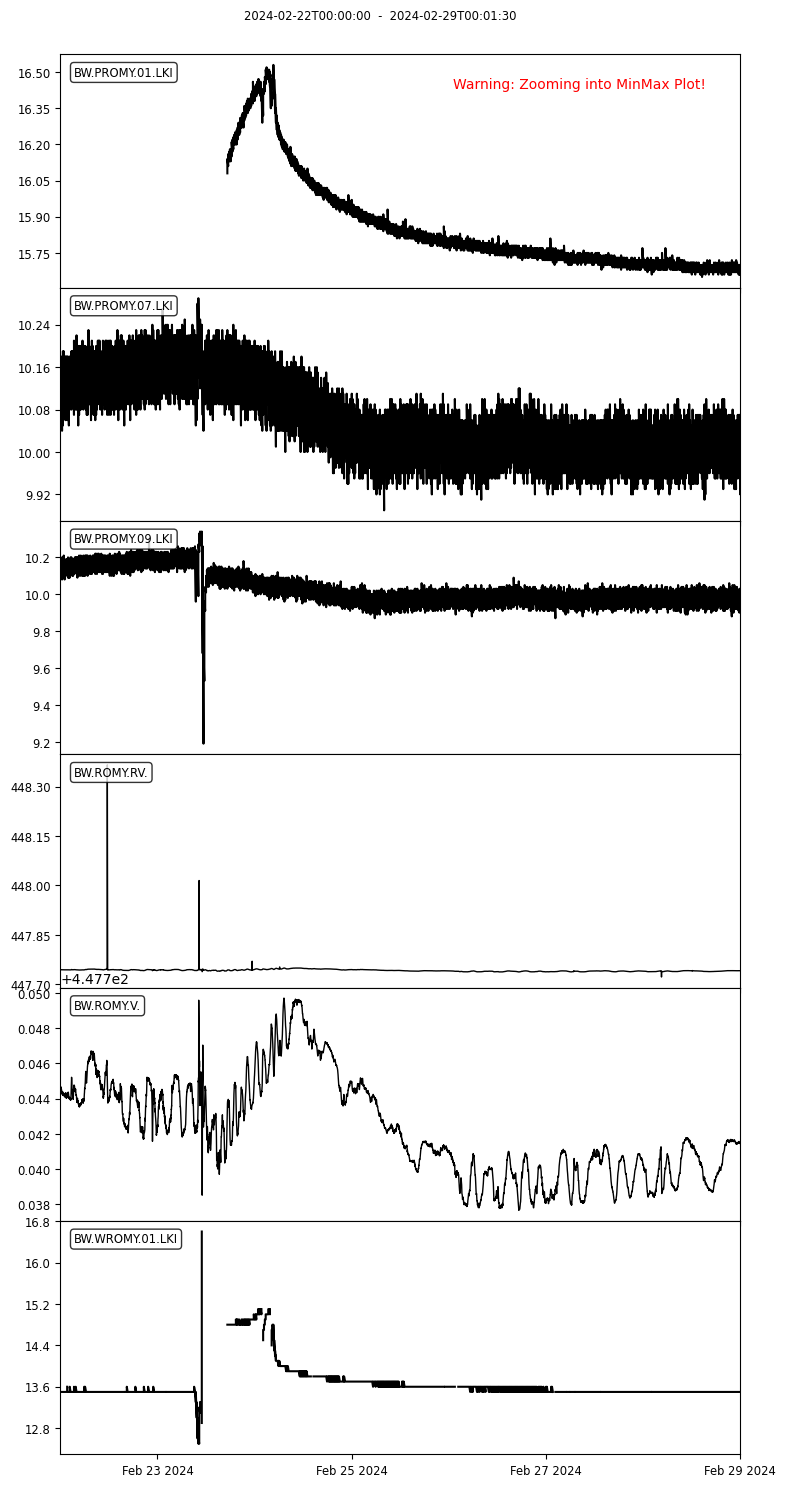

In [19]:
tr00 = Trace()
tr00.data = np.array(beatV.fj)
tr00.stats.delta = 60
tr00.stats.starttime = beatV.times_utc.iloc[0]
tr00.stats.network = "BW"
tr00.stats.station = "ROMY"
tr00.stats.location = "RV"

tr01 = Trace()
tr01.data = np.array(beatV.fj_inter)
tr01.stats.delta = 60
tr01.stats.starttime = beatV.times_utc.iloc[0]
tr01.stats.network = "BW"
tr01.stats.station = "ROMY"
tr01.stats.location = "V"

st_all = Stream()
st_all += tr00.copy()
st_all += tr01.copy()
st_all += ps.copy()

print(st_all)

# st_all.resample(0.01)

st_all.plot(equal_scale=False);

3 Trace(s) in Stream:
BW.ROMY.V.      | 2024-02-22T00:02:30.000000Z - 2024-02-28T23:57:30.000000Z | 100.0 s, 6046 samples
BW.PROMY.07.LKI | 2024-02-22T00:02:30.000000Z - 2024-02-28T23:57:30.000000Z | 100.0 s, 6046 samples
BW.PROMY.09.LKI | 2024-02-22T00:02:30.000000Z - 2024-02-28T23:57:30.000000Z | 100.0 s, 6046 samples


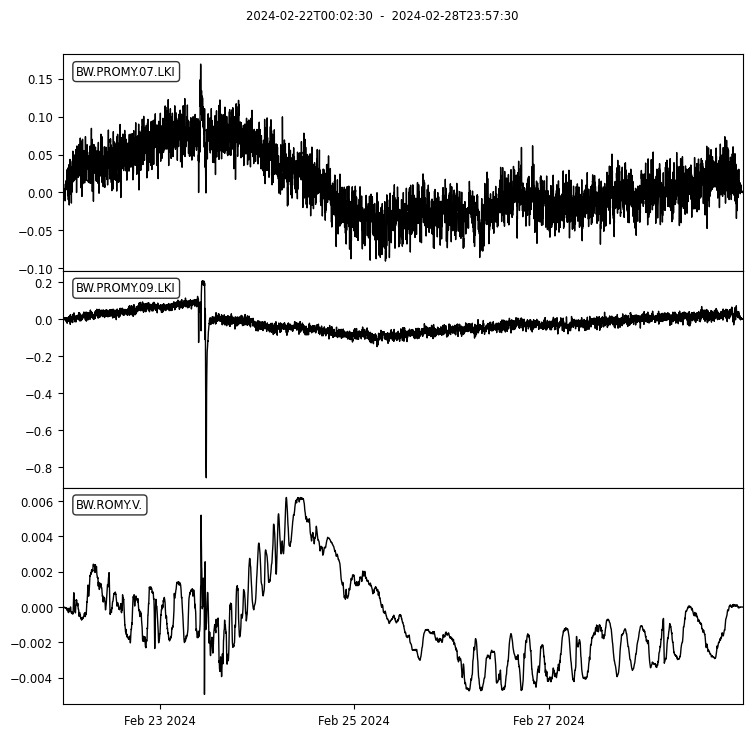

In [20]:
tr00 = Trace()
tr00.data = np.array(beatV.fj)
tr00.stats.delta = 60
tr00.stats.starttime = beatV.times_utc.iloc[0]
tr00.stats.network = "BW"
tr00.stats.station = "ROMY"
tr00.stats.location = "RV"

tr01 = Trace()
tr01.data = np.array(beatV.fj_inter)
tr01.stats.delta = 60
tr01.stats.starttime = beatV.times_utc.iloc[0]
tr01.stats.network = "BW"
tr01.stats.station = "ROMY"
tr01.stats.location = "V"

st_all2 = Stream()
st_all2 += tr01.copy()
st_all2 += ps.select(location="07").copy()
st_all2 += ps.select(location="09").copy()

st_all2 = st_all2.detrend("demean")
st_all2 = st_all2.detrend("simple")
st_all2 = st_all2.taper(0.01)

st_all2 = st_all2.trim(st_all2[0].stats.starttime + 120, st_all2[0].stats.endtime - 120)

st_all2 = st_all2.resample(0.01)

print(st_all2)

st_all2.plot(equal_scale=False);

/tmp/ipykernel_1355173/1449026040.py:110: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(tcklbls)
/tmp/ipykernel_1355173/1449026040.py:113: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(tcklbls)


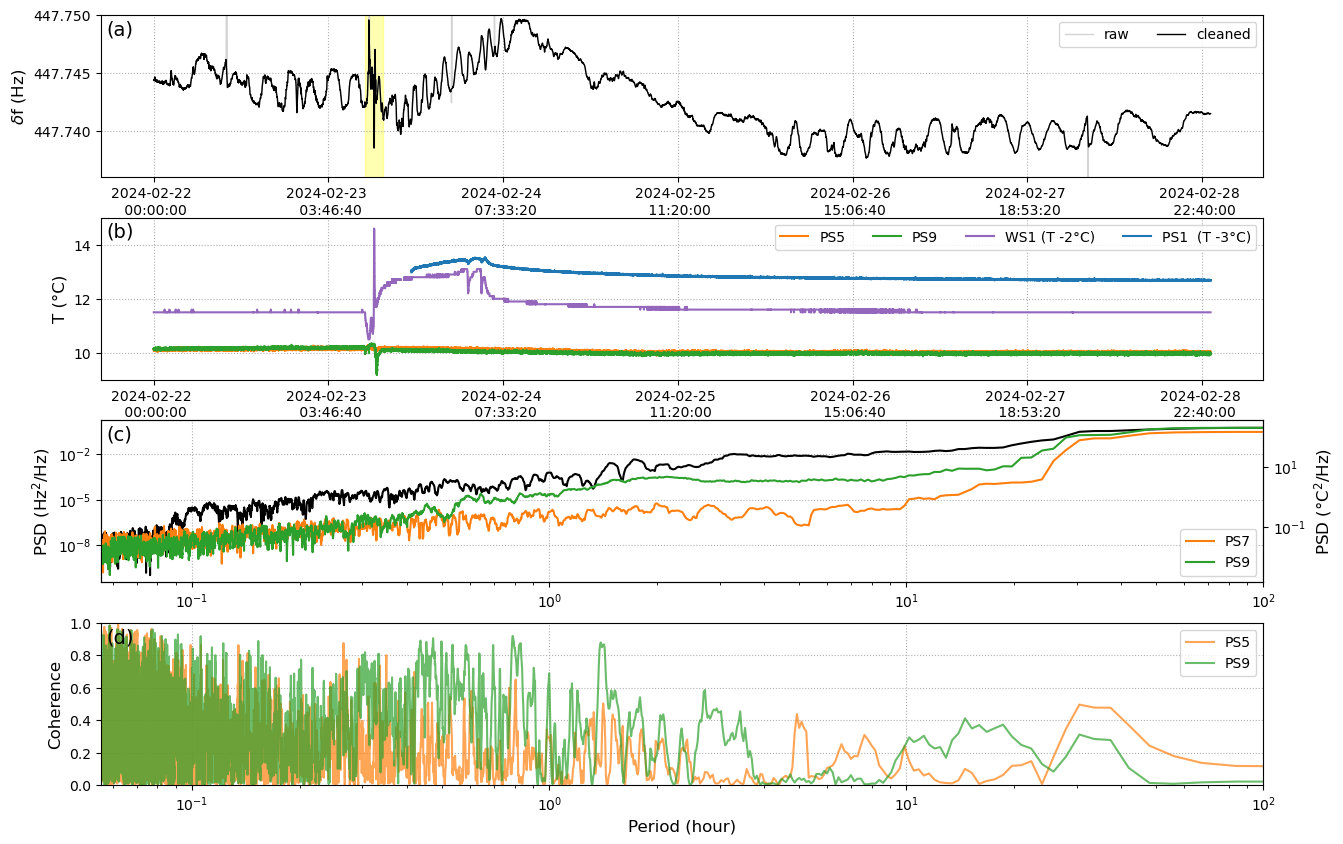

In [21]:
def __makeplot(st0, st1):

    from functions.multitaper_coherence import __multitaper_coherence
    from functions.reduce import __reduce
    from functions.get_fft import __get_fft



    dat0 = st1.select(station="ROMY", location="V")[0].data

    # dat1 = st1.select(station="PROMY", location="01")[0].data
    dat2 = st1.select(station="PROMY", location="07")[0].data
    dat3 = st1.select(station="PROMY", location="09")[0].data
    # dat4 = st1.select(station="WROMY", location="01")[0].data

    dt, df = st1[0].stats.delta, st1[0].stats.sampling_rate

    # out01 = __multitaper_coherence(dat0, dat1, dt, n_taper=20, time_bandwidth=3.5, method=0)
    out02 = __multitaper_coherence(dat0, dat2, dt, n_taper=20, time_bandwidth=3.5, method=0)
    out03 = __multitaper_coherence(dat0, dat3, dt, n_taper=20, time_bandwidth=3.5, method=0)
    # out04 = __multitaper_coherence(dat0, dat4, dt, n_taper=20, time_bandwidth=3.5, method=0)

    # f0, psd0, pha0 = __get_fft(dat0, 60)
    # f1, psd1, pha1 = __get_fft(dat1, dt)
    # f2, psd2, pha2 = __get_fft(dat2, 1)
    # f3, psd3, pha3 = __get_fft(dat3, 1)
    # f4, psd4, pha4 = __get_fft(dat4, 1)


    Nrow, Ncol = 4, 1

    font = 12

    ref_date = config['tbeg'].date

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 10), sharex=False)

    plt.subplots_adjust(hspace=0.25)

    # time_scaling = 1/86400
    time_scaling = 1

    ax[0].plot(st0.select(station="ROMY", location="RV")[0].times(reftime=UTCDateTime(ref_date)),
               st0.select(station="ROMY", location="RV")[0].data, color="lightgrey", label="raw", lw=1)
    ax[0].plot(st0.select(station="ROMY", location="V")[0].times(reftime=UTCDateTime(ref_date)),
               st0.select(station="ROMY", location="V")[0].data, color="black", label="cleaned", lw=1)


    ax[0].set_ylim(flim1, flim2)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\delta$f (Hz)", fontsize=font)



    ax[1].plot(st0.select(station="PROMY", location="07")[0].times(reftime=UTCDateTime(ref_date)),
               st0.select(station="PROMY", location="07")[0].data, color="tab:orange", label="PS5")
    ax[1].plot(st0.select(station="PROMY", location="09")[0].times(reftime=UTCDateTime(ref_date)),
               st0.select(station="PROMY", location="09")[0].data, color="tab:green", label="PS9")
    ax[1].plot(st0.select(station="WROMY", location="01")[0].times(reftime=UTCDateTime(ref_date)),
              st0.select(station="WROMY", location="01")[0].data-2, color="tab:purple", label="WS1 (T -2°C)")
    ax[1].plot(st0.select(station="PROMY", location="01")[0].times(reftime=UTCDateTime(ref_date)),
              st0.select(station="PROMY", location="01")[0].data-3, color="tab:blue", label="PS1  (T -3°C)")
    ax[1].set_ylabel("T (°C)", fontsize=font)
    ax[1].set_ylim(9, 15)



    ax[2].plot(1/out02['ff1'][1:]/3600, out02['psd1'][1:], color="k")
    ax[2].set_xscale("log")
    ax[2].set_yscale("log")
    ax[2].set_ylabel(f"PSD (Hz$^2$/Hz)", fontsize=font)
    ax[2].set_xlim(right=100)


    ax22 = ax[2].twinx()
    # ax22.plot(1/f0[1:]/3600, psd0[1:], color="black", label="FJ")
    # ax22.plot(1/f2[1:]/3600, psd2[1:], color="tab:orange", label="PS7")
    # ax22.plot(1/f3[1:]/3600, psd3[1:], color="tab:green", label="PS9")
    # ax22.plot(1/f4[1:]/3600, psd4[1:], color="tab:purple", label="WS1")
    ax22.plot(1/out02['ff2'][1:]/3600, out02['psd2'][1:], color="tab:orange", label="PS7")
    ax22.plot(1/out03['ff2'][1:]/3600, out03['psd2'][1:], color="tab:green", label="PS9")
    # ax22.plot(1/out04['ff2'][1:]/3600, out04['psd2'][1:], color="tab:purple", label="WS1")
    ax22.set_xscale("log")
    ax22.set_yscale("log")
    ax22.set_ylabel(f"PSD (°C$^2$/Hz)", fontsize=font)
    ax22.set_xlim(1/out02['ff2'][-1]/3600, 100)


    ax[3].plot(1/out02['fcoh'][1:]/3600, out02['coh'][1:], alpha=0.7, color="tab:orange", label="PS5")
    ax[3].plot(1/out03['fcoh'][1:]/3600, out03['coh'][1:], alpha=0.7, color="tab:green", label="PS9")
    # ax[3].plot(1/out04['fcoh'][1:]/3600, out04['coh'][1:], alpha=0.7, color="tab:purple", label="WS1")
    ax[3].set_xscale("log")
    ax[3].set_ylabel("Coherence", fontsize=font)
    ax[3].set_xlabel("Period (hour)", fontsize=font)
    ax[3].set_ylim(0, 1)
    ax[3].set_xlim(1/out02['fcoh'][-1]/3600, 100)


    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)

    ax[0].legend(loc=1, ncol=3)
    ax[1].legend(loc=1, ncol=4)
    ax22.legend(loc=4, ncol=1)
    ax[3].legend(loc=1, ncol=1)

    ## add dates to x-axis
    tcks = ax[0].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[0].set_xticklabels(tcklbls)
    tcks = ax[1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[1].set_xticklabels(tcklbls)

    ## add labels for subplots
    for _k, ll in enumerate(['(a)', '(b)', '(c)','(d)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)

    ## add maintenance times
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        ax[0].fill_betweenx([-1000, 1000], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot(st_all, st_all2)

fig.savefig(config['path_to_figs']+f"SF_RV_Case{case}_spectra_temperature.png", format="png", dpi=150, bbox_inches='tight')


## Convert to Tilt

In [22]:
def __sagnac_to_tilt(data, ring):

    from numpy import pi, sqrt, arccos, deg2rad, arcsin

    dip = {"Z":0, "U":109.5, "V":70.5, "W":70.5}

    L = {"Z":11.2, "U":12, "V":12, "W":12}

    ## Scale factor
    S = (sqrt(3)*L[ring])/(3*632.8e-9)

    ## ROMY latitude
    lat = 48.162941

    ## nominal Earth rotation
    omegaE = 2*pi/86400

    return arcsin(data /omegaE /S) - deg2rad(lat) - deg2rad(dip[ring])

In [23]:
beatV['tilt'] = __sagnac_to_tilt(beatV['fj_reduced'], "V")

beatV['tilt_reduced'] = beatV.tilt - np.nanmean(beatV.tilt.iloc[:600])


In [24]:
def __makeplot():

    Nrow, Ncol = 2, 1

    font = 12

    time_scaling = 1/86400
    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beatV.times_utc_sec*time_scaling, beatV.fj_reduced, color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\Delta f$ (Hz)", fontsize=font)

    ax[1].plot(beatV.times_utc_sec*time_scaling, beatV.tilt_reduced*tilt_scaling, color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")


    ax[1].set_ylabel("N-S Tilt ($\mu$rad)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    # ax[0].set_ylim(-0.04, 0.07)

    ## add dates to x-axis
    # ref_date = UTCDateTime(beatV.times_utc.iloc[0][:10])
    # tcks = ax[Nrow-1].get_xticks()
    # tcklbls = [str(UTCDateTime(ref_date+t).date) for t in tcks]
    # ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

# fig = __makeplot();


### Load Tilt Data

In [25]:
from andbro__read_sds import __read_sds
from andbro__readYaml import __readYaml
from functions.conversion_to_tilt import __conversion_to_tilt

  -> converted data of ROMYT


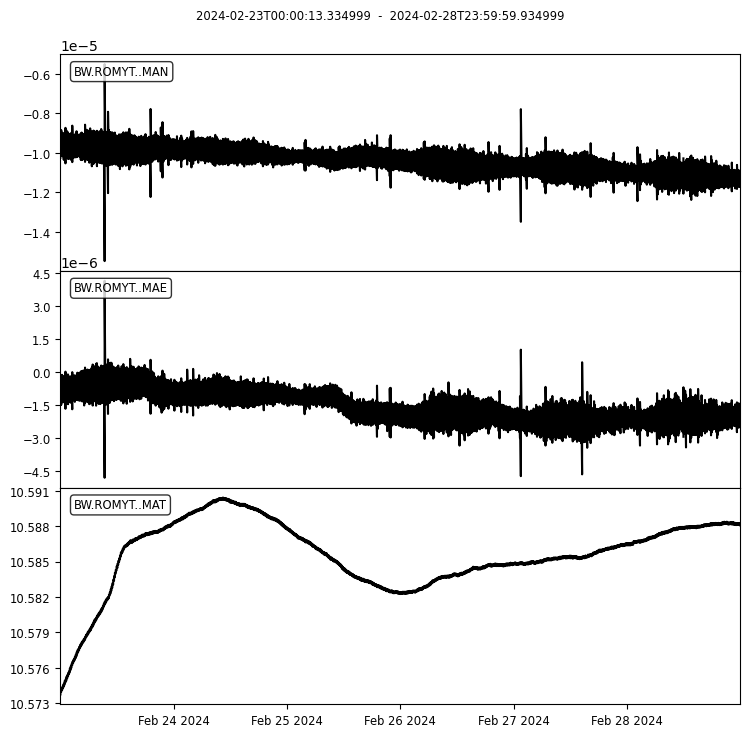

In [26]:
# path_to_tilt = data_path+"TiltmeterDataBackup/Tilt_downsampled/"
path_to_tilt = archive_path+"romy_archive/"

sta = "ROMYT"

tilt =  __read_sds(path_to_tilt, f"BW.{sta}..MAT", config['tbeg']+86400, config['tend']+600)
tilt += __read_sds(path_to_tilt, f"BW.{sta}..MAN", config['tbeg']+86400, config['tend']+600)
tilt += __read_sds(path_to_tilt, f"BW.{sta}..MAE", config['tbeg']+86400, config['tend']+600)

## tiltmeter configurations
confTilt = __readYaml(root_path+"Documents/ROMY/tiltmeter/", "tiltmeter.conf")

tilt = __conversion_to_tilt(tilt, confTilt[f'{sta}'])

tilt = tilt.trim(config['tbeg'], config['tend'])

tilt.plot(equal_scale=False);

gc.collect();

In [27]:
tilt.merge(fill_value="interpolate")


3 Trace(s) in Stream:
BW.ROMYT..MAE | 2024-02-23T00:00:13.334999Z - 2024-02-28T23:59:59.934999Z | 5.0 Hz, 2591934 samples
BW.ROMYT..MAN | 2024-02-23T00:00:24.334999Z - 2024-02-28T23:59:59.934999Z | 5.0 Hz, 2591879 samples
BW.ROMYT..MAT | 2024-02-23T00:01:13.934999Z - 2024-02-28T23:59:59.934999Z | 5.0 Hz, 2591631 samples

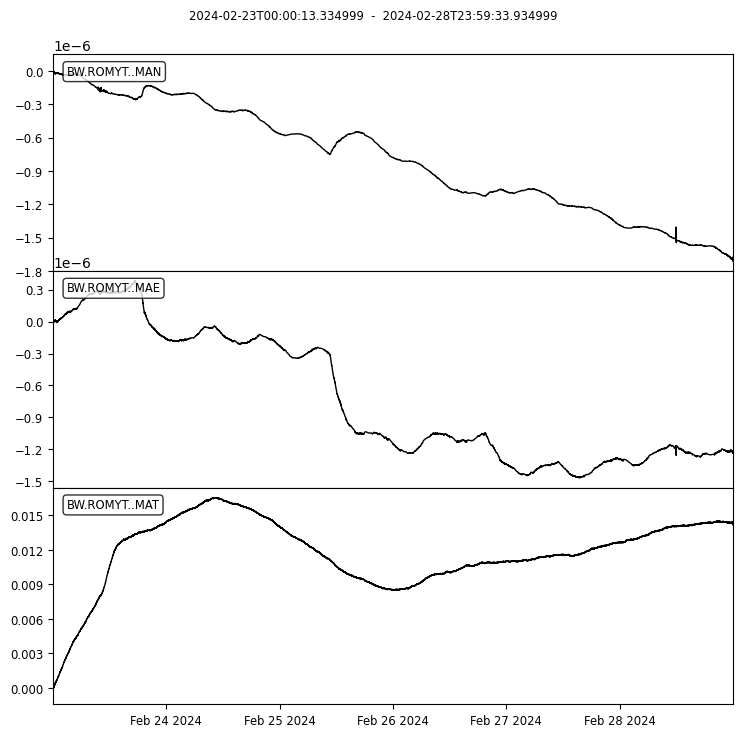

In [28]:
from functions.reduce import __reduce

tilt1 = tilt.copy()

for tr in tilt1:
    tr.data = __reduce(tr.data, 100)

# tilt1 = tilt1.detrend("demean")
# tilt1 = tilt1.detrend("simple")

# tilt1 = tilt1.taper(0.01)

# tilt1 = tilt1.filter("lowpass", freq=0.001, corners=4, zerophase=True)

tilt1 = tilt1.resample(0.5, no_filter=False)
tilt1 = tilt1.resample(0.1, no_filter=False)
tilt1 = tilt1.resample(0.05, no_filter=False)

tilt1.plot(equal_scale=False);


/tmp/ipykernel_1355173/3532629256.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[Nrow-1].set_xticklabels(tcklbls)


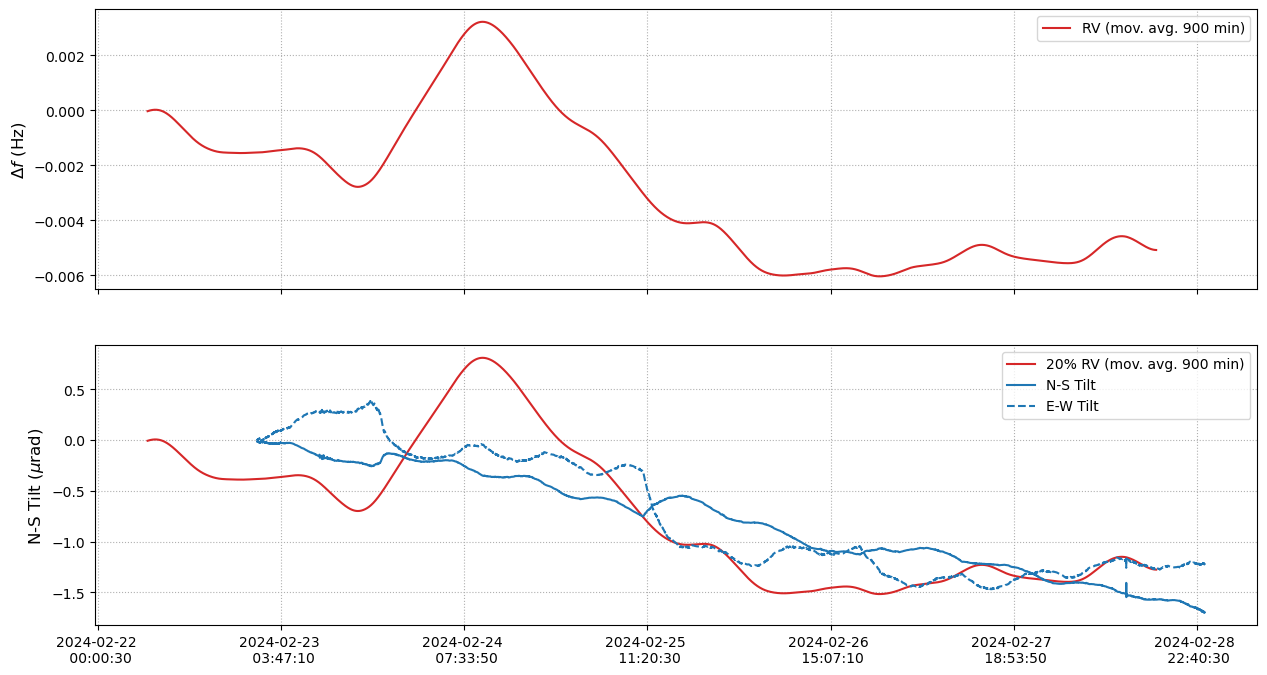

In [29]:
def __makeplot():

    from functions.reduce import __reduce

    Nrow, Ncol = 2, 1

    font = 12

    time_scaling = 1
    tilt_scaling = 1e6

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(15, 8), sharex=True)

    ax[0].plot(beatV.times_utc_sec*time_scaling, beatV.fj_reduced, color="tab:red", label=f"RV (mov. avg. {n_minutes} min)")

    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\Delta f$ (Hz)", fontsize=font)

    ax[1].plot(beatV.times_utc_sec*time_scaling, beatV.tilt_reduced*tilt_scaling*0.2, color="tab:red", label=f"20% RV (mov. avg. {n_minutes} min)")
    ax[1].plot(tilt1.select(channel="*N")[0].times(reftime=UTCDateTime(beatV.times_utc.iloc[0]))[30:-30]*time_scaling,
               tilt1.select(channel="*N")[0].data[30:-30]*tilt_scaling,
               color="tab:blue", label=f"N-S Tilt"
              )
    ax[1].plot(tilt1.select(channel="*E")[0].times(reftime=UTCDateTime(beatV.times_utc.iloc[0]))[30:-30]*time_scaling,
               (tilt1.select(channel="*E")[0].data[30:-30])*tilt_scaling,
               color="tab:blue", label=f"E-W Tilt", ls="--",
              )
    ax[1].set_ylabel("N-S Tilt ($\mu$rad)", fontsize=font)

    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)
        ax[_n].legend(loc=1)

    # ax[0].set_ylim(-0.04, 0.07)

    ## add dates to x-axis
    ref_date = UTCDateTime(beatV.times_utc.iloc[0])
    tcks = ax[Nrow-1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[Nrow-1].set_xticklabels(tcklbls)

    plt.show();
    return fig

fig = __makeplot();


## Add Beat U

In [63]:
def __load_beat(tbeg, tend, ring, path_to_data):

    from datetime import date
    from pandas import read_pickle, concat, DataFrame, date_range, merge
    from obspy import UTCDateTime


    tbeg, tend = UTCDateTime(tbeg), UTCDateTime(tend)

    dd1 = date.fromisoformat(str(tbeg.date))
    dd2 = date.fromisoformat(str(tend.date))

    # generate dates with 1 minute samples
    dates = date_range(dd1, dd2, freq="1min")

    # prepare data frame
    df0 = DataFrame()

    # prepare dummy data frame
    df_dummy = DataFrame()

    # add column for merging
    df_dummy["dt"] = [str(UTCDateTime(_d))[:16] for _d in dates]

    # add column to replace nan from merging with proper dates
    df_dummy["dummy_times"] = [UTCDateTime(_d) for _d in dates]


    for dat in date_range(dd1, dd2):

        # build file name
        file = f"{str(dat)[:4]}/R{ring}/FJ{ring}_"+str(dat)[:10].replace("-", "")+".pkl"

        try:
            df00 = read_pickle(path_to_data+file)
            df0 = concat([df0, df00])
        except:
            print(f"error for {file}")

    if df0.empty:
        print(" -> empty dataframe!")
        return df0

    # add column for merging
    df0["dt"] = [str(_dt)[:16] for _dt in df0.times_utc]

    try:
        df = merge(left=df_dummy, right=df0, on="dt", how="outer")
    except:
        print("-> no merge")

    # trim to given start and end date
    df = df[(df.dt >= tbeg) & (df.dt < tend)]

    # fill possible missing times_utc that turned to nan in merge with prepared dummy times
    df['times_utc'] = df['times_utc'].fillna(df['dummy_times'])

    # convert to UTCDateTime objects
    df['times_utc'] = [UTCDateTime(_t) for _t in df['times_utc']]

    ## trim to defined times
    # df = df[(df.times_utc >= tbeg) & (df.times_utc < tend)]

    ## correct seconds
    df['times_utc_sec'] = [abs(tbeg - UTCDateTime(_t)) for _t in df['times_utc']]

    return df

In [64]:
# beatU = __load_beat(config['tbeg'], config['tend'], "U", config['path_to_autodata'])
beatU = __load_sagnac_beat_data(config['tbeg'], config['tend'], "U", config['path_to_autodata'])

In [65]:
mltiU = __load_mlti(config['tbeg'], config['tend'], "U", archive_path)

mltiU_t1, mltiU_t2 = __get_mlti_intervals(mltiU.time_utc)

beatU = __mlti_intervals_to_NaN(beatU, "fj", "times_utc", mltiU_t1, mltiU_t2, t_offset_sec=180)

beatU['fj_inter'] = __interpolate_nan(np.array(beatU.fj_nan))


n_minutes = 15*60

beatU['fj_smooth'] = __smooth(beatU.fj_inter, n_minutes)

beatU['fj_reduced'] = beatU['fj_smooth'] - np.abs(np.nanmean(beatU['fj_smooth'].iloc[:500]))


8 Trace(s) in Stream:
BW.ROMY.RV.     | 2024-02-22T00:00:30.000000Z - 2024-02-27T23:59:30.000000Z | 60.0 s, 8640 samples
BW.ROMY.V.      | 2024-02-22T00:00:30.000000Z - 2024-02-27T23:59:30.000000Z | 60.0 s, 8640 samples
BW.ROMY.RU.     | 2024-02-22T00:00:30.000000Z - 2024-02-27T23:59:30.000000Z | 60.0 s, 8640 samples
BW.ROMY.U.      | 2024-02-22T00:00:30.000000Z - 2024-02-27T23:59:30.000000Z | 60.0 s, 8640 samples
BW.PROMY.07.LKI | 2024-02-22T00:00:00.000000Z - 2024-02-27T23:59:30.000000Z | 1.0 Hz, 518371 samples
BW.PROMY.09.LKI | 2024-02-22T00:00:00.000000Z - 2024-02-27T23:59:30.000000Z | 1.0 Hz, 518371 samples
BW.PROMY.01.LKI | 2024-02-23T00:00:00.000000Z - 2024-02-27T23:59:30.000000Z | 1.0 Hz, 431971 samples
BW.WROMY.01.LKI | 2024-02-22T00:00:00.000000Z - 2024-02-27T23:59:30.000000Z | 1.0 Hz, 518371 samples


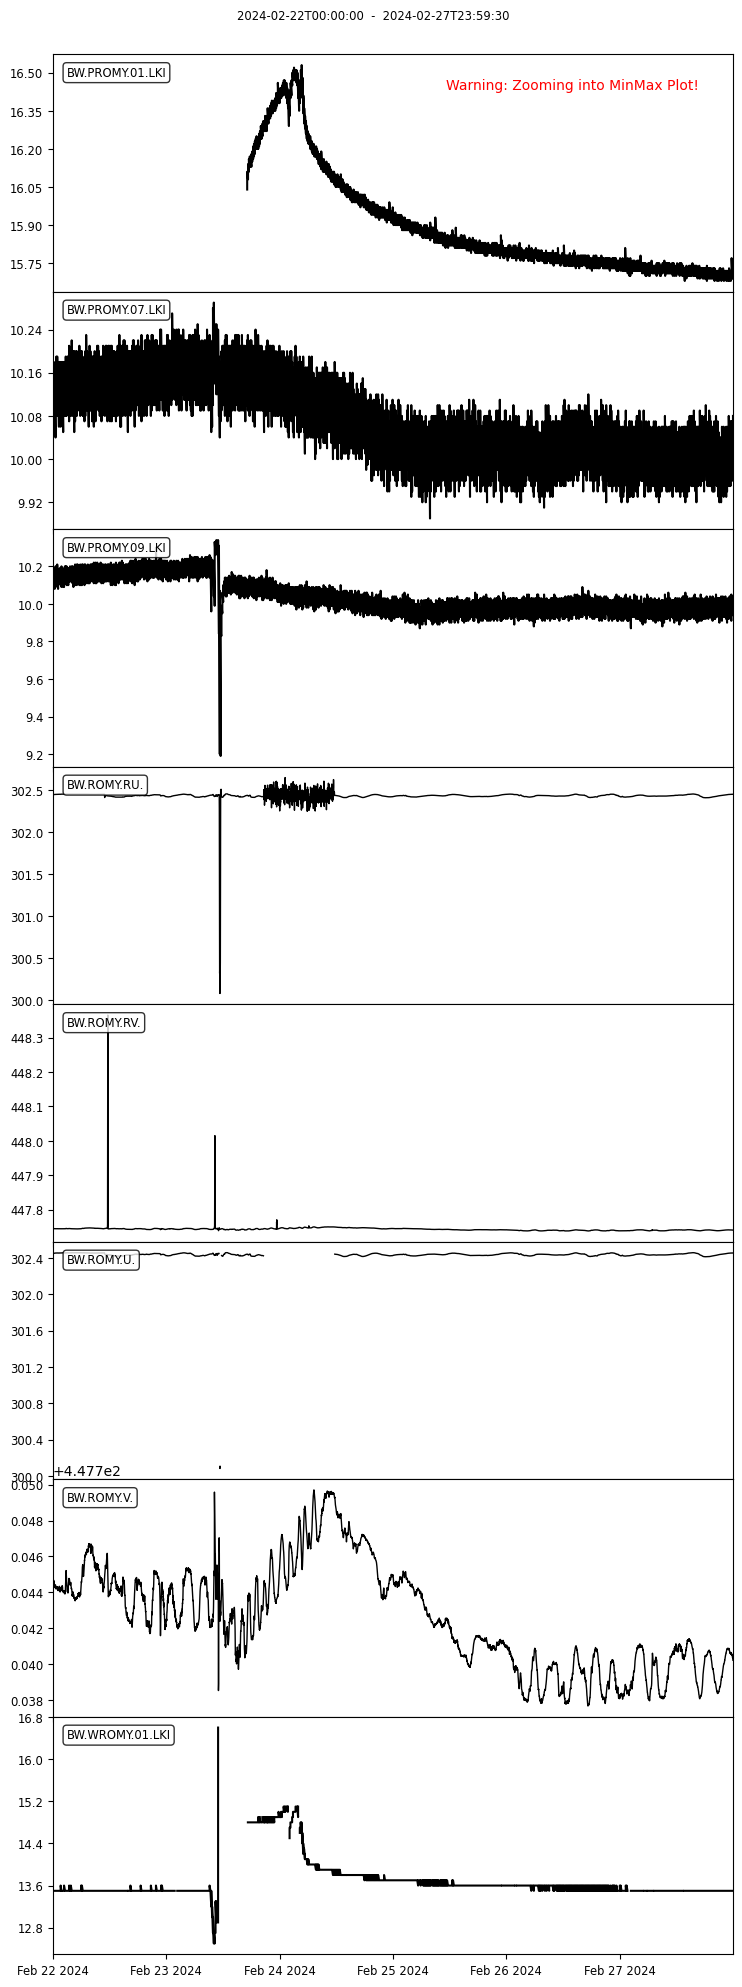

In [71]:
st_all2 = Stream()

tr00 = Trace()
tr00.data = np.array(beatV.fj)
tr00.stats.delta = 60
tr00.stats.starttime = beatV.times_utc.iloc[0]
tr00.stats.network = "BW"
tr00.stats.station = "ROMY"
tr00.stats.location = "RV"

st_all2 += tr00.copy()

tr01 = Trace()
tr01.data = np.array(beatV.fj_inter)
tr01.stats.delta = 60
tr01.stats.starttime = beatV.times_utc.iloc[0]
tr01.stats.network = "BW"
tr01.stats.station = "ROMY"
tr01.stats.location = "V"

st_all2 += tr01.copy()

tr00 = Trace()
tr00.data = np.array(beatU.fj)
tr00.stats.delta = 60
tr00.stats.starttime = beatU.times_utc.iloc[0]
tr00.stats.network = "BW"
tr00.stats.station = "ROMY"
tr00.stats.location = "RU"

st_all2 += tr00.copy()

tr01 = Trace()
tr01.data = np.array(beatU.fj_nan)
tr01.stats.delta = 60
tr01.stats.starttime = beatU.times_utc.iloc[0]
tr01.stats.network = "BW"
tr01.stats.station = "ROMY"
tr01.stats.location = "U"

st_all2 += tr01.copy()


st_all2 += ps.select(location="07").copy()
st_all2 += ps.select(location="09").copy()
st_all2 += ps.select(location="01").copy()

# st_all2 = st_all2.detrend("demean")
# st_all2 = st_all2.detrend("simple")
# st_all2 = st_all2.taper(0.01)

# st_all2 = st_all2.trim(st_all2[0].stats.starttime + 120, st_all2[0].stats.endtime - 120)

# st_all2 = st_all2.resample(0.01)

st_all2.trim(config['tbeg'], config['tend']-86400)

print(st_all2)

st_all2.plot(equal_scale=False);

/tmp/ipykernel_1355173/1033887258.py:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(tcklbls)
/tmp/ipykernel_1355173/1033887258.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(tcklbls)


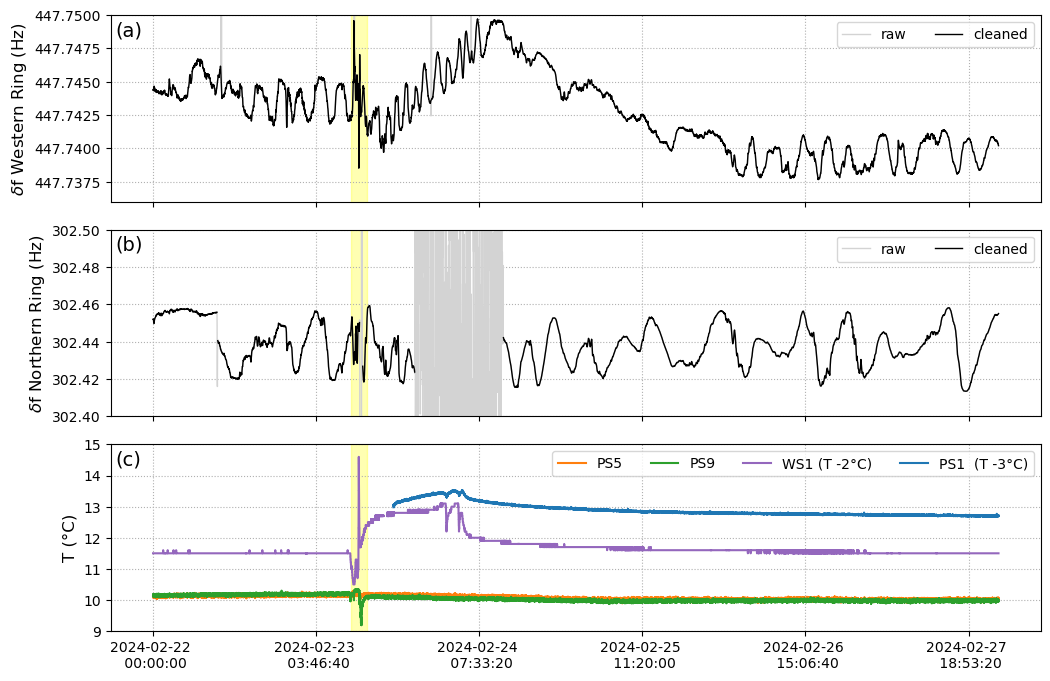

In [75]:
def __makeplot(st0):

    from functions.multitaper_coherence import __multitaper_coherence
    from functions.reduce import __reduce
    from functions.get_fft import __get_fft


    Nrow, Ncol = 3, 1

    font = 12

    ref_date = config['tbeg'].date

    fig, ax = plt.subplots(Nrow, Ncol, figsize=(12, 8), sharex=True)

    plt.subplots_adjust(hspace=0.15)


    ax[0].plot(st0.select(station="ROMY", location="RV")[0].times(reftime=UTCDateTime(ref_date)),
               st0.select(station="ROMY", location="RV")[0].data, color="lightgrey", label="raw", lw=1)
    ax[0].plot(st0.select(station="ROMY", location="V")[0].times(reftime=UTCDateTime(ref_date)),
               st0.select(station="ROMY", location="V")[0].data, color="black", label="cleaned", lw=1)


    ax[0].set_ylim(flim1, flim2)
    ax[0].ticklabel_format(useOffset=False)
    ax[0].set_ylabel("$\delta$f Western Ring (Hz)", fontsize=font)


    ax[1].plot(st0.select(station="ROMY", location="RU")[0].times(reftime=UTCDateTime(ref_date)),
               st0.select(station="ROMY", location="RU")[0].data, color="lightgrey", label="raw", lw=1)
    ax[1].plot(st0.select(station="ROMY", location="U")[0].times(reftime=UTCDateTime(ref_date)),
               st0.select(station="ROMY", location="U")[0].data, color="black", label="cleaned", lw=1)

    ax[1].set_ylim(302.4, 302.5)
    ax[1].set_ylabel("$\delta$f Northern Ring (Hz)", fontsize=font)


    ax[2].plot(st0.select(station="PROMY", location="07")[0].times(reftime=UTCDateTime(ref_date)),
               st0.select(station="PROMY", location="07")[0].data, color="tab:orange", label="PS5")
    ax[2].plot(st0.select(station="PROMY", location="09")[0].times(reftime=UTCDateTime(ref_date)),
               st0.select(station="PROMY", location="09")[0].data, color="tab:green", label="PS9")
    ax[2].plot(st0.select(station="WROMY", location="01")[0].times(reftime=UTCDateTime(ref_date)),
               st0.select(station="WROMY", location="01")[0].data-2, color="tab:purple", label="WS1 (T -2°C)")
    ax[2].plot(st0.select(station="PROMY", location="01")[0].times(reftime=UTCDateTime(ref_date)),
               st0.select(station="PROMY", location="01")[0].data-3, color="tab:blue", label="PS1  (T -3°C)")
    ax[2].set_ylabel("T (°C)", fontsize=font)
    ax[2].set_ylim(9, 15)


    for _n in range(Nrow):
        ax[_n].grid(ls=":", zorder=0)

    ax[0].legend(loc=1, ncol=3)
    ax[1].legend(loc=1, ncol=4)
    ax[2].legend(loc=1, ncol=4)

    ## add dates to x-axis
    tcks = ax[0].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[0].set_xticklabels(tcklbls)
    tcks = ax[1].get_xticks()
    tcklbls = [f"{UTCDateTime(UTCDateTime(ref_date)+t).date} \n {UTCDateTime(UTCDateTime(ref_date)+t).time}" for t in tcks]
    ax[1].set_xticklabels(tcklbls)

    ## add labels for subplots
    for _k, ll in enumerate(['(a)', '(b)', '(c)']):
        ax[_k].text(.005, .97, ll, ha='left', va='top', transform=ax[_k].transAxes, fontsize=font+2)

    ## add maintenance times
    for lx1, lx2 in zip(lxx_t1, lxx_t2):
        lx1_sec = lx1-UTCDateTime(ref_date)
        lx2_sec = lx2-UTCDateTime(ref_date)
        ax[0].fill_betweenx([-1000, 1000], lx1_sec, lx2_sec, color="yellow", alpha=0.3)
        ax[1].fill_betweenx([-1000, 1000], lx1_sec, lx2_sec, color="yellow", alpha=0.3)
        ax[2].fill_betweenx([-1000, 1000], lx1_sec, lx2_sec, color="yellow", alpha=0.3)

    gc.collect()

    plt.show();
    return fig

fig = __makeplot(st_all2)

fig.savefig(config['path_to_figs']+f"SF_RV_RU_Case{case}_temperature.png", format="png", dpi=150, bbox_inches='tight')
